In [1]:
import numpy as np
import pandas as pd
from pycytominer.cyto_utils import infer_cp_features
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../../scripts")
from utils import load_data
from tensorflow import keras
from scipy.stats import pearsonr, ttest_ind, ttest_1samp

import seaborn
from sklearn.decomposition import PCA
import random

In [2]:
np.random.seed(82)
NUM_RANDOM_SAMPLES = 10

In [3]:
data_dict = load_data(["complete"])
meta_features = infer_cp_features(data_dict["complete"], metadata=True)
cp_features = infer_cp_features(data_dict["complete"])

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [4]:
latent_dim = 10
latent_space_columns = np.arange(0,latent_dim)
latent_space_columns = [str(latent_space_column) for latent_space_column in latent_space_columns]

In [5]:
latent_df = pd.read_csv("level5Latent.csv").drop("Unnamed: 0", axis = 1)
pca = PCA(n_components=latent_dim)
pca_latent_df = pd.DataFrame(pca.fit_transform(complete_features_df), columns = latent_space_columns)

In [6]:
moa_df = pd.read_csv("repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=complete_meta_df['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
meta_moa_latent_df = pd.concat([complete_meta_df,moa_df,latent_df], axis=1)
meta_moa_pca_latent_df = pd.concat([complete_meta_df,moa_df,pca_latent_df], axis=1)
meta_moa_complete_df = pd.concat([complete_meta_df,moa_df,complete_features_df], axis=1)

# fill negative control DMSO profiles, change the NaN MOA label to be DMSO
meta_moa_latent_df.loc[meta_moa_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'
meta_moa_pca_latent_df.loc[meta_moa_pca_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'
meta_moa_complete_df.loc[meta_moa_complete_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'

#drop profiles with NaN MOAs
meta_moa_latent_df = meta_moa_latent_df.dropna(subset=['moa']).reset_index(drop = True)
meta_moa_pca_latent_df = meta_moa_pca_latent_df.dropna(subset=['moa']).reset_index(drop = True)
meta_moa_complete_df = meta_moa_complete_df.dropna(subset=['moa']).reset_index(drop = True)

# add columns to the dataframe that are randomnly shuffled permutations of the MOA column
for i in range(NUM_RANDOM_SAMPLES):
    random_moa_labels = meta_moa_latent_df[['moa','Metadata_dose_recode']].sample(frac=1).reset_index(drop=True)    
    random_moa_labels = random_moa_labels.rename(columns={'moa': 'random_moa_labels' + str(i), 'Metadata_dose_recode': 'random_dose' + str(i)})
    meta_moa_latent_df = pd.concat([random_moa_labels, meta_moa_latent_df], axis=1)
    meta_moa_pca_latent_df = pd.concat([random_moa_labels, meta_moa_pca_latent_df], axis=1)
    meta_moa_complete_df = pd.concat([random_moa_labels, meta_moa_complete_df], axis=1)

meta_moa_complete_df.head()

,random_moa_labels9,random_dose9,random_moa_labels8,random_dose8,random_moa_labels7,random_dose7,random_moa_labels6,random_dose6,random_moa_labels5,random_dose5,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,retinoid receptor agonist,3,transthyretin amyloid inhibitor,5,androgen receptor antagonist,2,serotonin receptor antagonist,1,retinoid receptor agonist,6,...,0.164260,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,phosphodiesterase inhibitor,3,topoisomerase inhibitor,5,calcium channel blocker,4,beta lactamase inhibitor,6,mTOR inhibitor|PI3K inhibitor,1,...,0.184110,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,glucokinase inhibitor,1,NFkB pathway inhibitor|proteasome inhibitor,7,histamine receptor antagonist,3,VEGFR inhibitor,2,DMSO,0,...,0.175640,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086
3,leukotriene synthesis inhibitor|lipoxygenase i...,3,prostacyclin analog,4,nucleoside reverse transcriptase inhibitor,2,platelet aggregation inhibitor,6,WEE1 kinase inhibitor,3,...,0.141310,0.18764,0.17342,0.18641,0.54696,0.44890,0.40042,0.30187,0.35082,0.32103
4,leukotriene receptor antagonist,2,opioid receptor agonist|opioid receptor antago...,6,protein synthesis inhibitor,2,DMSO,0,prostanoid receptor antagonist,1,...,0.094635,0.16631,0.15218,0.15540,0.56882,0.46601,0.40149,0.31658,0.36167,0.33338


In [7]:
moas_occurrence = pd.read_csv("moas_occurrence.tsv", sep = "\t")
moas_occurrence.index = moas_occurrence['moa']
moas_occurrence = moas_occurrence.drop('moa', axis = 1)

#We only want moa combinations with enough data, so we pick A|B such that there are at least 5 A|B, 5 A, and 5 B.
valid_pipes = moas_occurrence[((moas_occurrence != 0).all(axis = 1)) & (moas_occurrence['full moa occurrence'] > 0) & (moas_occurrence['moa1 occurrence'] > 0)& (moas_occurrence['moa2 occurrence'] > 0)].index
valid_pipes = valid_pipes[valid_pipes.str.count("\|") == 1]

In [8]:
def subset_by_moa(pipe, df_name, column):
    moas = pipe.split("|")
    subset_df = pd.concat([df_name[df_name[column] == moas[0]],df_name[df_name[column] == moas[1]]])
    return subset_df

def LSA(A, B, D):
    return A-D+B

In [9]:
#calculate means for each A and B in each A|B.
subset_means = []
subset_random_means = []
subset_pca_means = []
subset_pca_random_means = []
subset_complete_means = []
subset_complete_random_means = []

for pipe in valid_pipes:
    subset = subset_by_moa(pipe, meta_moa_latent_df, 'moa')
    subset_mean = subset.groupby(['moa','Metadata_dose_recode'])[latent_space_columns].mean()
    subset_pca = subset_by_moa(pipe, meta_moa_pca_latent_df, 'moa')
    subset_pca_mean = subset_pca.groupby(['moa','Metadata_dose_recode'])[latent_space_columns].mean()
    subset_complete = subset_by_moa(pipe, meta_moa_complete_df, 'moa')
    subset_complete_mean = subset_complete.groupby(['moa','Metadata_dose_recode'])[complete_features_df.columns].mean()
    
    
    subsets_random_mean = []
    subsets_pca_random_mean = []
    subsets_complete_random_mean = []
    for i in range(NUM_RANDOM_SAMPLES):
        moa_label = 'random_moa_labels' + str(i)
        dose_label = 'random_dose' + str(i)
        subset_random = subset_by_moa(pipe, meta_moa_latent_df, moa_label)
        subset_random_mean = subset_random.groupby([moa_label, dose_label])[latent_space_columns].mean()
        subsets_random_mean.append(subset_random_mean)
        
        subset_pca_random = subset_by_moa(pipe, meta_moa_pca_latent_df, moa_label)
        subset_pca_random_mean = subset_pca_random.groupby([moa_label, dose_label])[latent_space_columns].mean()
        subsets_pca_random_mean.append(subset_pca_random_mean)
        
        subset_complete_random = subset_by_moa(pipe, meta_moa_complete_df, moa_label)
        subset_complete_random_mean = subset_complete_random.groupby([moa_label, dose_label])[complete_features_df.columns].mean()
        subsets_complete_random_mean.append(subset_complete_random_mean)
    
    subset_means.append(subset_mean)
    subset_pca_means.append(subset_pca_mean)
    subset_complete_means.append(subset_complete_mean)
    
    subset_random_means.append(subsets_random_mean)
    subset_pca_random_means.append(subsets_pca_random_mean)
    subset_complete_random_means.append(subsets_complete_random_mean)



In [10]:
#calculate means for DMSO
DMSO = meta_moa_latent_df[meta_moa_latent_df.moa == 'DMSO']
DMSO_pca = meta_moa_pca_latent_df[meta_moa_pca_latent_df.moa == 'DMSO']
DMSO_complete = meta_moa_complete_df[meta_moa_complete_df.moa == 'DMSO']

DMSO_means = np.mean(DMSO[latent_space_columns])
DMSO_means_pca = np.mean(DMSO_pca[latent_space_columns])
DMSO_means_complete = np.mean(DMSO_complete[complete_features_df.columns])


DMSO_means_random = []
DMSO_means_pca_random = []
DMSO_means_complete_random = []

for i in range(NUM_RANDOM_SAMPLES):
    label = 'random_moa_labels' + str(i)
    DMSO_random = meta_moa_latent_df[meta_moa_latent_df[label] == 'DMSO']
    DMSO_means_random.append(np.mean(DMSO_random[latent_space_columns]))

    DMSO_pca_random = meta_moa_pca_latent_df[meta_moa_pca_latent_df[label] == 'DMSO']
    DMSO_means_pca_random.append(np.mean(DMSO_pca_random[latent_space_columns]))
    
    DMSO_complete_random = meta_moa_complete_df[meta_moa_complete_df[label] == 'DMSO']
    DMSO_means_complete_random.append(np.mean(DMSO_complete_random[complete_features_df.columns]))

In [11]:
def determine_overlapping_doses(subset_mean):
    overlapping_doses = []
    doses = subset_mean.index.get_level_values(1).to_list()
    for i in range(max(doses)):
        if doses.count(i) >= 2:
            overlapping_doses.append(i)
    return overlapping_doses

In [12]:
#perform latent space arithmetic
representations_after_LSA = []
representations_after_LSA_random = []
representations_after_LSA_pca = []
representations_after_LSA_pca_random = []
representations_after_LSA_complete = []
representations_after_LSA_complete_random = []


for i in range(len(subset_means)):
    doses = determine_overlapping_doses(subset_means[i])
    representations_after_LSA_per_dose = []
    representations_after_LSA_pca_per_dose = []
    representations_after_LSA_complete_per_dose = []
    representations_after_LSA_random_per_dose = []
    representations_after_LSA_pca_random_per_dose = []
    representations_after_LSA_complete_random_per_dose = []
    for dose in doses:
        representation_after_LSA = LSA(subset_means[i].loc[valid_pipes[i].split("|")[0]].loc[dose],subset_means[i].loc[valid_pipes[i].split("|")[1]].loc[dose],DMSO_means)
        representation_after_LSA = pd.DataFrame(representation_after_LSA).transpose()
        representations_after_LSA_per_dose.append(representation_after_LSA)

        representation_after_LSA_pca = LSA(subset_pca_means[i].loc[valid_pipes[i].split("|")[0]].loc[dose],subset_pca_means[i].loc[valid_pipes[i].split("|")[1]].loc[dose],DMSO_means_pca)
        representation_after_LSA_pca = pd.DataFrame(representation_after_LSA_pca).transpose()
        representations_after_LSA_pca_per_dose.append(representation_after_LSA_pca)

        representation_after_LSA_complete = LSA(subset_complete_means[i].loc[valid_pipes[i].split("|")[0]].loc[dose],subset_complete_means[i].loc[valid_pipes[i].split("|")[1]].loc[dose],DMSO_means_complete)
        representation_after_LSA_complete = pd.DataFrame(representation_after_LSA_complete).transpose()
        representations_after_LSA_complete_per_dose.append(representation_after_LSA_complete)

        LSA_random_1pipe = []
        PCA_random_1pipe = []
        complete_random_1pipe = []
        for j in range(NUM_RANDOM_SAMPLES):
            representation_after_LSA_random = LSA(subset_random_means[i][j].loc[valid_pipes[i].split("|")[0]].loc[dose],subset_random_means[i][j].loc[valid_pipes[i].split("|")[1]].loc[dose],DMSO_means_random[j])
            representation_after_LSA_random = pd.DataFrame(representation_after_LSA_random).transpose()
            LSA_random_1pipe.append(representation_after_LSA_random)    

            representation_after_LSA_pca_random = LSA(subset_pca_random_means[i][j].loc[valid_pipes[i].split("|")[0]].loc[dose],subset_pca_random_means[i][j].loc[valid_pipes[i].split("|")[1]].loc[dose],DMSO_means_pca_random[j])
            representation_after_LSA_pca_random = pd.DataFrame(representation_after_LSA_pca_random).transpose()
            PCA_random_1pipe.append(representation_after_LSA_pca_random)

            representation_after_LSA_complete_random = LSA(subset_complete_random_means[i][j].loc[valid_pipes[i].split("|")[0]].loc[dose],subset_complete_random_means[i][j].loc[valid_pipes[i].split("|")[1]].loc[dose],DMSO_means_complete_random[j])
            representation_after_LSA_complete_random = pd.DataFrame(representation_after_LSA_complete_random).transpose()
            complete_random_1pipe.append(representation_after_LSA_complete_random)

        representations_after_LSA_random_per_dose.append(LSA_random_1pipe)
        representations_after_LSA_pca_random_per_dose.append(PCA_random_1pipe)
        representations_after_LSA_complete_random_per_dose.append(complete_random_1pipe)
        
    representations_after_LSA.append(representations_after_LSA_per_dose)
    representations_after_LSA_pca.append(representations_after_LSA_pca_per_dose)
    representations_after_LSA_complete.append(representations_after_LSA_complete_per_dose)
    representations_after_LSA_random.append(representations_after_LSA_random_per_dose)
    representations_after_LSA_pca_random.append(representations_after_LSA_pca_random_per_dose)
    representations_after_LSA_complete_random.append(representations_after_LSA_complete_random_per_dose)


In [13]:
decoder = keras.models.load_model("../2.train/level5Decoder")


In [19]:
#decode each latent space representation

predictions = []
predictions_random = []
predictions_pca = []
predictions_pca_random = []
predictions_complete = []
predictions_complete_random = []

for i in range(len(representations_after_LSA)):
    
    predictions_per_dose = []
    predictions_random_per_dose = []
    predictions_pca_per_dose = []
    predictions_pca_random_per_dose = []
    predictions_complete_per_dose = []
    predictions_complete_random_per_dose = []
    
    for dose in range(len(representations_after_LSA[i])):
        predictions_per_dose.append(decoder.predict(representations_after_LSA[i][dose]))
        predictions_pca_per_dose.append(pca.inverse_transform(representations_after_LSA_pca[i][dose]))
        predictions_complete_per_dose.append(representations_after_LSA_complete[i][dose].values.tolist())

        predictions_random_1pipe = []
        predictions_pca_random_1pipe = []
        predictions_complete_random_1pipe = []

        for j in range(NUM_RANDOM_SAMPLES):
            predictions_random_1pipe.append(decoder.predict(representations_after_LSA_random[i][dose][j]))
            predictions_pca_random_1pipe.append(pca.inverse_transform(representations_after_LSA_pca_random[i][dose][j]))
            predictions_complete_random_1pipe.append(representations_after_LSA_complete_random[i][dose][j].values.tolist())

        predictions_random_per_dose.append(predictions_random_1pipe)
        predictions_pca_random_per_dose.append(predictions_pca_random_1pipe)
        predictions_complete_random_per_dose.append(predictions_complete_random_1pipe)
    
    predictions.append(predictions_per_dose)
    predictions_random.append(predictions_random_per_dose)
    predictions_pca.append(predictions_pca_per_dose)
    predictions_pca_random.append(predictions_pca_random_per_dose)
    predictions_complete.append(predictions_complete_per_dose)
    predictions_complete_random.append(predictions_complete_random_per_dose)
    
        
predictions = np.array(predictions)
predictions_random = np.array(predictions_random)
predictions_pca = np.array(predictions_pca)
predictions_pca_random = np.array(predictions_pca_random)
predictions_complete = np.array(predictions_complete)
predictions_complete_random = np.array(predictions_complete_random)

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) 

In [ ]:
# meta_moa_complete_df.columns.to_list()

In [20]:
mean_of_moas = meta_moa_complete_df.groupby(['moa','Metadata_dose_recode']).mean().loc[:,'Cells_AreaShape_FormFactor':]
mean_of_moas = mean_of_moas[mean_of_moas.index.get_level_values(0).str.contains('\|')]

Int64Index([1, 2, 3, 4, 5, 6, 7], dtype='int64', name='Metadata_dose_recode')

In [42]:
# calculates all L2 distances for both per MOA combo and general distribution comparison for all MOA combos
L2 = []
L2_random = []
L2_pca = []
L2_pca_random = []
L2_complete = []
L2_complete_random = []

moa_dose = []
per_moa_pvalues_vae = []
per_moa_tstat_vae = []
per_moa_pvalues_pca = []
per_moa_tstat_pca = []
per_moa_pvalues_complete = []
per_moa_tstat_complete = []

for i in range(len(predictions)):
    dose_max = min(len(predictions[i]), len(mean_of_moas[mean_of_moas.index.get_level_values(0) == valid_pipes[i]].index.get_level_values(1)))
    for dose in range(dose_max):
        desired_moa = np.array(mean_of_moas[(mean_of_moas.index.get_level_values(0) == valid_pipes[i]) 
                                            & (mean_of_moas.index.get_level_values(1) == dose+1)])

        L2.append(np.linalg.norm(predictions[i][dose][0]-desired_moa[0]))
        L2_pca.append(np.linalg.norm(predictions_pca[i][dose][0]-desired_moa[0]))
        L2_complete.append(np.linalg.norm(predictions_complete[i][dose][0]-desired_moa[0]))

        
        L2_random_per_moa = []
        L2_pca_random_per_moa = []
        L2_complete_random_per_moa = []
        for j in range(NUM_RANDOM_SAMPLES):
            L2_random_per_moa.append(np.linalg.norm(predictions_random[i][dose][j][0]-desired_moa[0]))
            L2_pca_random_per_moa.append(np.linalg.norm(predictions_pca_random[i][dose][j][0]-desired_moa[0]))
            L2_complete_random_per_moa.append(np.linalg.norm(predictions_complete_random[i][dose][j][0]-desired_moa[0]))

        L2_random += L2_random_per_moa
        L2_pca_random += L2_pca_random_per_moa
        L2_complete_random += L2_complete_random_per_moa

        tstat_vae, pval_vae = ttest_1samp(L2_random_per_moa, np.linalg.norm(predictions[i][dose][0]-desired_moa[0]))
        tstat_pca, pval_pca = ttest_1samp(L2_pca_random_per_moa, np.linalg.norm(predictions_pca[i][dose][0]-desired_moa[0]))
        tstat_complete, pval_complete = ttest_1samp(L2_complete_random_per_moa, np.linalg.norm(predictions_complete[i][dose][0]-desired_moa[0]))
        
        moa_dose.append(valid_pipes[i] + ' ' + str(dose))
        per_moa_pvalues_vae.append(pval_vae)
        per_moa_tstat_vae.append(tstat_vae)
        per_moa_pvalues_pca.append(pval_pca)
        per_moa_tstat_pca.append(tstat_pca)
        per_moa_pvalues_complete.append(pval_complete)
        per_moa_tstat_complete.append(tstat_complete)


In [43]:
per_moa_performance_df = pd.DataFrame({"MOA_dose":moa_dose,"vae pvalue":per_moa_pvalues_vae,"vae tstat":per_moa_tstat_vae,"pca pvalue":per_moa_pvalues_pca,"pca tstat":per_moa_tstat_pca})
per_moa_performance_df.to_csv('ttest_per_moa.tsv', sep = '\t')


In [44]:
per_moa_performance_df = per_moa_performance_df.sort_values('vae tstat')
per_moa_performance_df

,MOA_dose,vae pvalue,vae tstat,pca pvalue,pca tstat
225,RNA synthesis inhibitor|topoisomerase inhibitor 4,9.153238e-11,-33.549251,2.426472e-06,-10.476074
125,aromatase inhibitor|TRPV antagonist 4,8.920170e-09,-20.040190,4.340168e-05,-7.347212
165,cytochrome P450 inhibitor|protein synthesis in...,1.908491e-07,-14.116996,1.143989e-05,-8.682780
230,DNA synthesis inhibitor|thymidylate synthase i...,2.242724e-07,-13.855761,3.222781e-03,-3.976505
394,DNA synthesis inhibitor|microtubule inhibitor 4,1.053491e-06,-11.565549,8.468102e-04,-4.900716
...,...,...,...,...,...
200,microtubule inhibitor|tubulin polymerization i...,3.735703e-10,28.657411,3.040605e-07,13.375102
194,SRC inhibitor|tubulin polymerization inhibitor 3,1.992435e-10,30.750388,1.494944e-09,24.521021
2,NFkB pathway inhibitor|proteasome inhibitor 2,8.491581e-11,33.832151,3.467036e-07,13.172584
4,NFkB pathway inhibitor|proteasome inhibitor 4,1.106512e-11,42.484531,1.082953e-06,11.528002


In [45]:
well_predicted = per_moa_performance_df[per_moa_performance_df['vae tstat'] < 0]
well_predicted.to_csv('well_predicted_level5.csv')
well_predicted

,MOA_dose,vae pvalue,vae tstat,pca pvalue,pca tstat
225,RNA synthesis inhibitor|topoisomerase inhibitor 4,9.153238e-11,-33.549251,0.000002,-10.476074
125,aromatase inhibitor|TRPV antagonist 4,8.920170e-09,-20.040190,0.000043,-7.347212
165,cytochrome P450 inhibitor|protein synthesis in...,1.908491e-07,-14.116996,0.000011,-8.682780
230,DNA synthesis inhibitor|thymidylate synthase i...,2.242724e-07,-13.855761,0.003223,-3.976505
394,DNA synthesis inhibitor|microtubule inhibitor 4,1.053491e-06,-11.565549,0.000847,-4.900716
...,...,...,...,...,...
340,bacterial 30S ribosomal subunit inhibitor|bact...,9.652101e-01,-0.044845,0.032560,2.523898
217,cyclooxygenase inhibitor|PPAR receptor agonist 1,9.732815e-01,-0.034436,0.087012,1.920317
64,angiogenesis inhibitor|tumor necrosis factor p...,9.868849e-01,-0.016900,0.438841,0.809982
111,dopamine receptor antagonist|serotonin recepto...,9.882653e-01,-0.015121,0.026475,-2.650029


In [46]:
L2_df = pd.DataFrame(L2, columns = ['VAE Unshuffled'])
L2_random_df = pd.DataFrame(L2_random, columns = ['VAE Shuffled'])
L2_pca_df = pd.DataFrame(L2_pca, columns = ['PCA Unshuffled'])
L2_pca_random_df = pd.DataFrame(L2_pca_random, columns = ['PCA Shuffled'])
L2_complete_df = pd.DataFrame(L2_complete, columns = ['Complete Unshuffled'])
L2_complete_random_df = pd.DataFrame(L2_complete_random, columns = ['Complete Shuffled'])
L2_df = pd.concat([L2_df, L2_random_df, L2_pca_df, L2_pca_random_df, L2_complete_df, L2_complete_random_df], ignore_index = True, axis = 1)
L2_df.columns = ['VAE Unshuffled','VAE Shuffled','PCA Unshuffled','PCA Shuffled','Complete Unshuffled','Complete Shuffled']
L2_df.to_csv('L2_general.tsv', sep = '\t')


# L2_df = pd.DataFrame(L2, columns = ['VAE Unshuffled'])
# L2_random_df = pd.DataFrame(L2_random, columns = ['VAE Shuffled'])
# L2_pca_df = pd.DataFrame(L2_pca, columns = ['PCA Unshuffled'])
# L2_pca_random_df = pd.DataFrame(L2_pca_random, columns = ['PCA Shuffled'])
# L2_df = pd.concat([L2_df, L2_random_df, L2_pca_df, L2_pca_random_df], ignore_index = True, axis = 1)
# L2_df.columns = ['VAE Unshuffled','VAE Shuffled','PCA Unshuffled','PCA Shuffled']
# L2_df.to_csv('L2_general.tsv', sep = '\t')

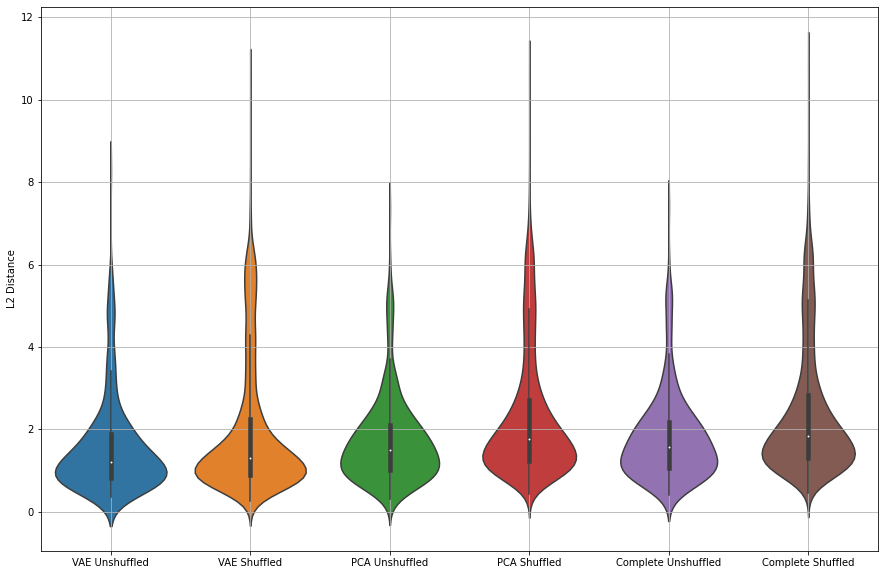

In [47]:
import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=(15, 10))
ax = seaborn.violinplot(data = L2_df)
ax.set(ylabel = "L2 Distance")
plt.grid()

plt.show()

In [48]:
L2_df.describe()

,VAE Unshuffled,VAE Shuffled,PCA Unshuffled,PCA Shuffled,Complete Unshuffled,Complete Shuffled
count,420.000000,4200.000000,420.000000,4200.000000,420.000000,4200.000000
mean,1.569104,1.948752,1.746006,2.293004,1.808736,2.377859
std,1.166976,1.604881,1.066890,1.528572,1.072871,1.543357
min,0.353465,0.271659,0.319346,0.437761,0.421866,0.453447
25%,0.814716,0.898832,1.014898,1.241698,1.055859,1.310417
50%,1.211580,1.306957,1.506157,1.761109,1.571191,1.832421
75%,1.880118,2.255241,2.111716,2.722098,2.179146,2.839467
max,8.299658,10.629701,7.360419,10.862853,7.406543,11.061021


In [49]:
# computing a 2-tailed 2-sample t-test. In the paper, we compute the one-tailed p-value by dividing the follwing p-value by 2
print(ttest_ind(L2_df['VAE Unshuffled'].dropna(), L2_df['VAE Shuffled']))
print(ttest_ind(L2_df['PCA Unshuffled'].dropna(), L2_df['PCA Shuffled']))
print(ttest_ind(L2_df['Complete Unshuffled'].dropna(), L2_df['Complete Shuffled']))
#1.29


Ttest_indResult(statistic=-4.724507092428577, pvalue=2.375226016615104e-06)
Ttest_indResult(statistic=-7.161029595245614, pvalue=9.273378106054009e-13)
Ttest_indResult(statistic=-7.380673255589622, pvalue=1.8578293240987998e-13)
